# Se crea un modelo de ML para definir caracteristicas como: 'Costo de Combustible', 'Costo Electrico', 'Nivel de Ruido'

# Luego se objetivisa a los 3 tipos de vehiculos: Convencional, Hibrido y Electrico.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # O el modelo que prefieras
from sklearn.metrics import accuracy_score  # O métricas como MSE si es regresión
import joblib


# Cargar el dataset
df = pd.read_csv('../Data/costo_operacional_vehiculos_clean.csv')

# Función para categorizar los vehículos
def categorize_vehicle(row):
    if row['Fuel_Type'] in ['Diesel', 'Petrol', 'Petrol/LPG']:
        return 'Convencional'
    elif row['Fuel_Type'] == 'Electricity':
        return 'Eléctrico'
    else:
        return 'Híbrido'

# Aplicar la función al dataframe
df['Vehicle_Type'] = df.apply(categorize_vehicle, axis=1)

# Verificar la distribución
print(df['Vehicle_Type'].value_counts())


# Preprocesamiento (asegúrate de limpiar y preparar los datos para ML)
df = df.dropna()  # Por ejemplo, eliminar valores nulos

# Definir las características (features) y la variable objetivo (target)
X = df[['Fuel_Cost', 'Electric_Cost', 'Noise_Level']]  # Ejemplo de características
y = df['Vehicle_Type']  # Objetivo de predicción (convencional, eléctrico, híbrido)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Vehicle_Type
Convencional    2710
Híbrido          884
Eléctrico        219
Name: count, dtype: int64


In [2]:
# Inicializar el modelo (en este caso, un Random Forest)
model = RandomForestClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo: {accuracy:.2f}')


Accuracy del modelo: 0.90


In [3]:
# Guardar el modelo en un archivo
joblib.dump(model, 'modelo_rf.joblib')


['modelo_rf.joblib']

In [ ]:
df = pd.read_csv('../Data/costo_operacional_vehiculos_clean.csv')

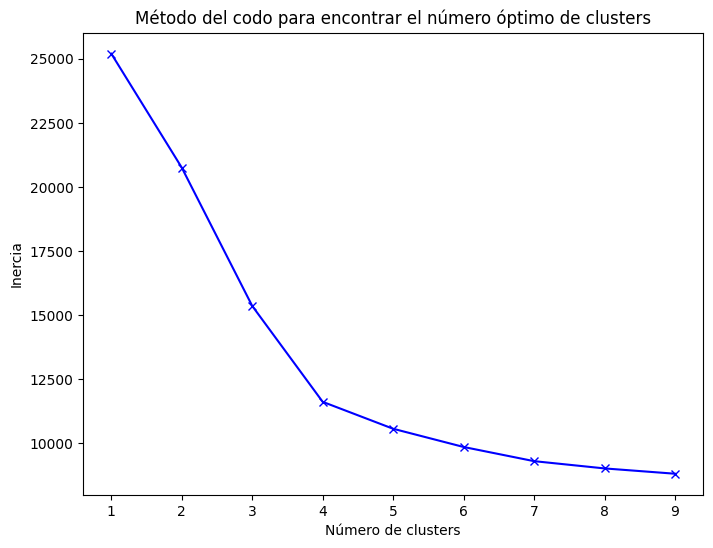

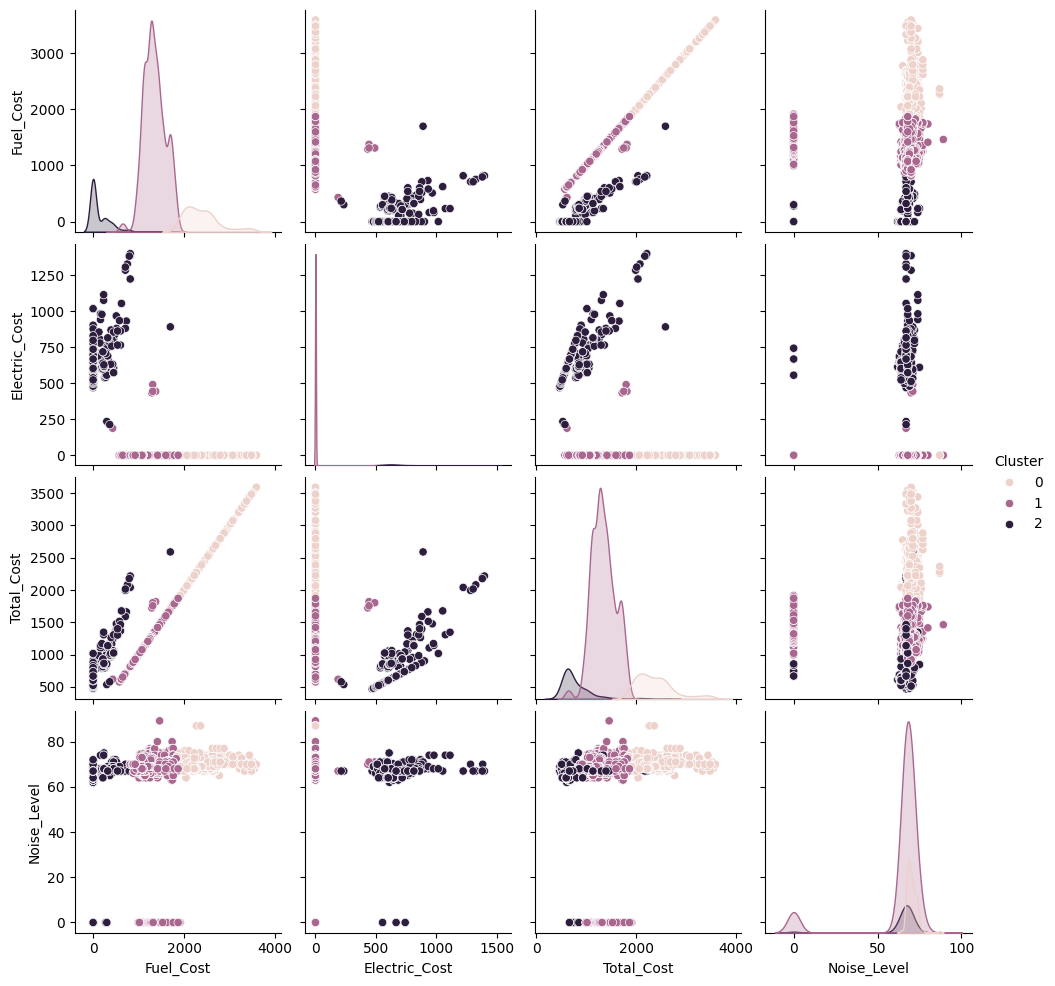

           Fuel_Cost  Electric_Cost   Total_Cost  Noise_Level  Cluster
Cluster                                                               
0        2384.254395       0.000000  2384.254395    70.222569      0.0
1        1343.086105       0.682183  1343.768288    63.204272      1.0
2         133.195596     669.310090   802.475287    65.690058      2.0


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_csv('../Data/costo_operacional_vehiculos_clean.csv')

# Seleccionar las columnas relevantes para la clusterización
columns_numerical = ['Fuel_Cost', 'Electric_Cost', 'Total_Cost', 'Noise_Level']
columns_categorical = ['Fuel_Type', 'Manuf', 'Model']

# Normalizar los datos numéricos
scaler = StandardScaler()
df_scaled_numerical = scaler.fit_transform(df[columns_numerical])

# Codificar las variables categóricas
encoder = OneHotEncoder(sparse_output=False)  # Cambiar 'sparse=False' a 'sparse_output=False'
df_encoded_categorical = encoder.fit_transform(df[columns_categorical])

# Combinar las columnas numéricas normalizadas y las categóricas codificadas
df_combined = pd.concat([pd.DataFrame(df_scaled_numerical), pd.DataFrame(df_encoded_categorical)], axis=1)

# Método del codo para encontrar el número óptimo de clusters
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_combined)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para encontrar el número óptimo de clusters')
plt.show()

# Aplicar K-means con el número óptimo de clusters
optimal_k = 3  # Ajustar según el gráfico del codo
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_combined)

# Visualizar los clusters
sns.pairplot(df, hue='Cluster', vars=columns_numerical)
plt.show()

# Analizar los clusters
# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['number']).columns

# Agrupar por cluster y calcular el promedio solo en las columnas numéricas
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

# Mostrar el resumen de los clusters
print(cluster_summary)



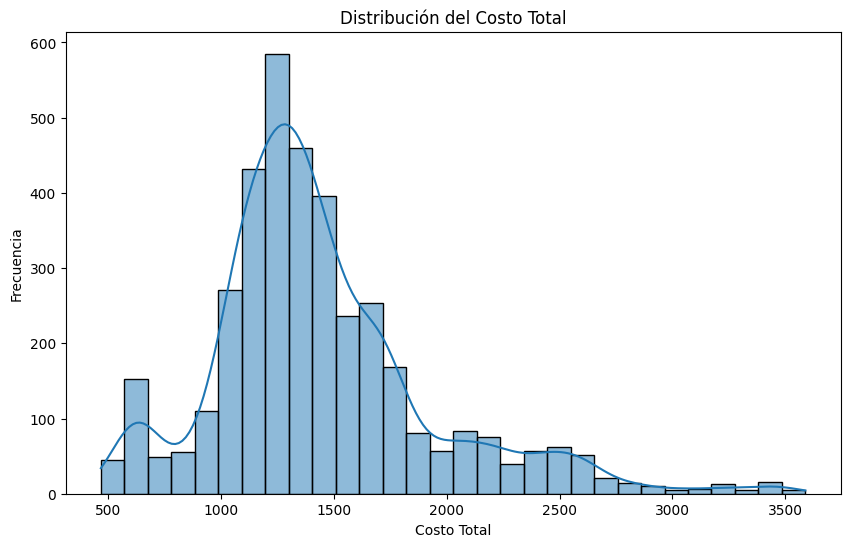

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de la distribución de Total_Cost
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Cost'], bins=30, kde=True)
plt.title('Distribución del Costo Total')
plt.xlabel('Costo Total')
plt.ylabel('Frecuencia')
plt.show()


In [6]:
# Calcular los percentiles
low_cost_threshold = df['Total_Cost'].quantile(0.33)  # Umbral para económico
high_cost_threshold = df['Total_Cost'].quantile(0.66)  # Umbral para caro

print(f"Umbral económico: {low_cost_threshold}")
print(f"Umbral caro: {high_cost_threshold}")


Umbral económico: 1225.1506828886374
Umbral caro: 1504.2483254004749


In [7]:
# Función para clasificar los vehículos
def clasificar_costo(total_cost):
    if total_cost <= low_cost_threshold:
        return 'Económico'
    elif total_cost <= high_cost_threshold:
        return 'Normal'
    else:
        return 'Caro'

# Crear la columna de categorías
df['Categoria_Costo'] = df['Total_Cost'].apply(clasificar_costo)

# Mostrar la distribución de las categorías
print(df['Categoria_Costo'].value_counts())


Categoria_Costo
Caro         1281
Económico    1267
Normal       1265
Name: count, dtype: int64


In [8]:
# Agrupar por fabricante, modelo y categoría
fabricante_modelo_costo = df.groupby(['Manuf', 'Model', 'Categoria_Costo']).size().reset_index(name='Cantidad')

# Mostrar los primeros resultados
print(fabricante_modelo_costo.head(10))


        Manuf         Model Categoria_Costo  Cantidad
0      ABARTH           595            Caro        28
1      ABARTH           595          Normal        13
2  ALFA ROMEO   Giulia MY21            Caro         8
3  ALFA ROMEO   Giulia MY21          Normal         2
4  ALFA ROMEO   Giulia MY22            Caro         1
5  ALFA ROMEO   Giulia MY22          Normal         1
6  ALFA ROMEO  Stelvio MY21            Caro         9
7  ALFA ROMEO  Stelvio MY21          Normal         2
8  ALFA ROMEO  Stelvio MY22            Caro         2
9      ALPINE          A110            Caro         8


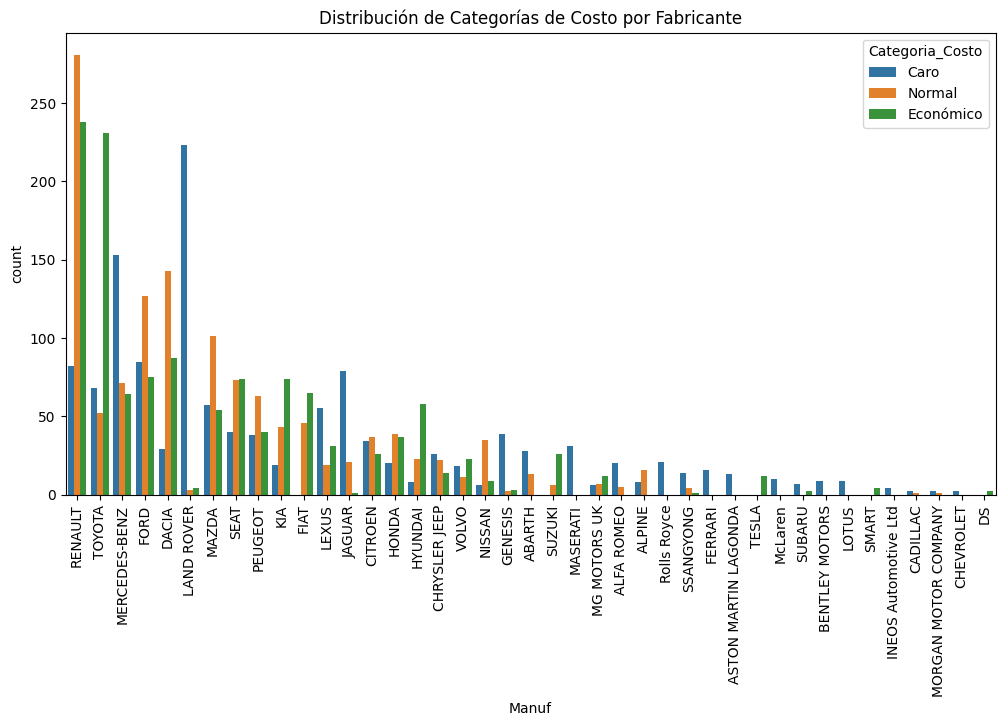

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Manuf', hue='Categoria_Costo', order=df['Manuf'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribución de Categorías de Costo por Fabricante')
plt.show()


# Preparar el modelo

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Cargar dataset y categorizar
df = pd.read_csv('../Data/car_resale_prices_clean.csv')
df['Vehicle_Type'] = df.apply(categorize_vehicle, axis=1)

X = df.drop('resale_price', axis=1)  # Características
y = df['resale_price']  # Variable objetivo


In [28]:
# Separar características y variable objetivo
X = df.drop('resale_price', axis=1)
y = df['resale_price']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Codificación de variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Imputar valores nulos en X_train y X_test
imputer_X = SimpleImputer(strategy='mean')
X_train = imputer_X.fit_transform(X_train)
X_test = imputer_X.transform(X_test)

# Imputar valores nulos en y_train
if y_train.isnull().any():
    imputer_y = SimpleImputer(strategy='mean')
    y_train = imputer_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Entrenar el modelo
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [29]:
import joblib

# Guardar el modelo entrenado en un archivo
joblib.dump(model, '../Modelos_ML/random_forest_regressor.joblib')


['../Modelos_ML/random_forest_regressor.joblib']